In [17]:
# this demo consider only known users, ignore the unknown users.

import pandas as pd
import numpy as np
import networkx as nx
import re
import os


In [18]:
class Edge:
    def __init__(self, content, from_user, to_user, foward_num, comment_num, like_num) -> None:
        """
        边的构造函数
        A转发B : from_user = A, to_user = B
        """
        self.content = content
        self.from_user = from_user
        self.to_user = to_user
        self.foward_num = foward_num
        self.comment_num = comment_num
        self.like_num = like_num

    def str_equal(self, edge):
        """
        通过content比较是否是同一条边。在边的去重时有用
        """
        return self.content == edge.content
    
    def __eq__(self, other) -> bool:
        """
        通过比较content+from_user+to_user比较是否是同一条边。边的去重时有用
        (注意：随时间变化转发链中的内容/点赞数可能会有不同。去重时不可能考虑到所有情况，尽量使重复边比较少)
        """
        return self.content == other.content and self.from_user == other.from_user and self.to_user == other.to_user

    def print_edge(self):
        return "(" + str(self.from_user) + ", " + str(self.to_user) + ")"

class Node:
    def __init__(self, user_id) -> None:
        """
        节点构造函数。一个用户抽象为一个节点
        forward: 当前用户引用其他用户产生的边
        forward_by: 当前用户被其他用户引用产生的边。A-->B-->C中, (A, B)就是在B的forward_by中
        """
        self.user_id = user_id
        self.forward: list[Edge] = []
        self.forward_by: list[Edge] = []

    def add_forward(self, forward_edge: Edge):
        """
        添加边。已经考虑去重
        下同
        """
        if forward_edge not in self.forward:
            self.forward.append(forward_edge)

    def add_forward_by(self, forward_by_edge: Edge):
        if forward_by_edge not in self.forward_by:
            self.forward_by.append(forward_by_edge)

    def remove_forward(self, forward_edge: Edge):
        self.forward.remove(forward_edge)

    def remove_forward_by(self, forward_by_edge: Edge):
        self.forward_by.remove(forward_by_edge)

    def get_deg(self):
        """
        获取节点的度。即入度+出度
        """
        return len(self.forward) + len(self.forward_by)  # TODO: ?

    
class Graph:
    def __init__(self) -> None:
        """
        整张图的构造函数。图中只存储节点
        """
        self.known_users: list[Node] = []
        
    def add_known_user(self, known_user):
        self.known_users.append(known_user)

    def print_graph(self):
        """
        用邻接表的形式打印图
        """
        print("print known user list")
        for known_user in self.known_users:
            print(f'{known_user.user_id}: {[edge.print_edge() for edge in known_user.forward]}')

    def get_nodes(self, n):
        """
        获取节点(只挑选度 >= n 的节点)。画图用
        """
        nodes = []
        nodes.extend([user.user_id for user in self.known_users if user.get_deg() >= n])
        return nodes
    
    def get_edges(self, n):
        """
        获取边。画图用
        """
        nodes = self.get_nodes(n)
        edges = []
        for user in self.known_users:
            for edge in user.forward:
                if edge.from_user in nodes or edge.to_user in nodes:
                    edges.append((edge.from_user, edge.to_user))
        return list(edges)
    
    def get_user_by_id(self, user_id):
        """
        通过user_id获取节点
        """
        for user in self.known_users:
            if user.user_id == user_id:
                return user
        return None
    
    
    def pruning(self, n):
        """
        剪枝。只保留度 > n 的那些节点.同时可以选择要不要把对应的边全部删除
        """
        for i in range(len(self.known_users) - 1, -1, -1):
            user = self.known_users[i]
            if user.get_deg() < n:
                self.remove_all_edges(user)  # 到底要不要删边？
                del self.known_users[i]

    def remove_all_edges(self, user: Node):  # 删除所有相关的边，主要是删除边另一头节点的这条边
        for edge in user.forward:
            another_user = self.get_user_by_id(edge.to_user)
            if another_user is not None:
                another_user.remove_forward_by(edge)
        for edge in user.forward_by:
            another_user = self.get_user_by_id(edge.from_user)
            if another_user is not None:
                another_user.remove_forward(edge)
            


In [19]:
# 读取转发链 --> 字典

# 正则匹配第一个//@前的内容，如果没有//@，则返回全部内容
def get_first_comment(text):
    """
    正则匹配第一个//@前的内容，如果没有//@，则返回全部内容
    :param text: 评论内容
    :return: 第一个//@前的内容
    """
    # 正则匹配第一个//@前的内容，如果没有//@，则返回全部内容
    pattern = re.compile(r'//@.*')
    # 匹配结果
    result = pattern.findall(str(text))
    # 如果没有//@，则返回全部内容
    if len(result) == 0:
        return text
    # 如果有//@，则返回第一个//@前的内容
    else:
        # return result[0]
        text = re.split(r'//@', text)
        return text[0]
    
# 正则匹配每一个//@后面的内容到下一个//@前的内容，如果没有//@，则返回//后的内容
def get_comment(text):
    """
    正则匹配每一个//@后面的内容到下一个//@前的内容，如果没有//@，则返回//后的内容
    :param text: 评论内容
    :return: 每一个//@后面的内容到下一个//@前的内容
    """
    # 正则匹配每一个//@后面的内容到下一个//@前的内容，如果没有//@，则返回//后的内容
    pattern = re.compile(r'//@.*')
    # 匹配结果
    result = pattern.findall(str(text))
    # 如果没有//@，则返回//后的内容
    if len(result) == 0:
        return None
    # 如果有//@，则返回每一个//@后面的内容到下一个//@前的内容
    else:
        # 以//@为分隔符，分割字符串
        result = re.split(r'//@', text)
        # 去掉第一个//@前的内容
        result = result[1:]
        ans = {}
        # 遍历每一个result，按照:分割字符串，前面的为key，后面的为value
        for i in range(len(result)):
            # 按照:分割字符串
            tmp = result[i].split(':')
            # 第一个元素为key，后面的字符串用:连接为value
            ans[tmp[0]] = ':'.join(tmp[1:])
        return ans


def read_data(filename : str):
    """
    读取数据
    :param filename: 数据文件名
    :return: 数据
    """
    # 读取数据，读取其中除了最后一行的数据
    file = open(filename, encoding='gb18030', errors='ignore')
    # 获取行数
    lines = len(file.readlines())
    # 关闭文件
    file.close()
    file = open(filename, encoding='gb18030', errors='ignore')
    # 读取数据，读取其中除了最后一行的数据
    data = pd.read_csv(file, on_bad_lines='skip', nrows=lines-20)
    

    # 提取全文内容
    df = data['全文内容']
    # 提取第一个//@前的内容
    df_context = df.apply(get_first_comment)
    # 提取每一个//@后面的内容到下一个//@前的内容
    df_comment = df.apply(get_comment)
    # 将df_comment、df_context、data['标题／微博内容']、data['评论数']、data['点赞数']、data['转发数']合并为一个DataFrame
    data = pd.concat([df_context, df_comment, data['标题／微博内容'], data['评论数'], data['点赞数'], data['转发数']], axis=1)
    # 重命名列名
    data.columns = ['context', 'comment', 'title', 'comment_num', 'like_num', 'forward_num']
    # 写入文件
    # data.to_csv('../data/2022年全国高考A平台数据/34918267_new.csv', index=False, encoding='gbk')
    # 将data按照字典形式返回
    data = data.to_dict(orient='records')
    # 返回数据
    return data



filename = 'data/2022年全国高考A平台数据/34918267.csv'
data = read_data(filename)
# for record in data:
#     print(data)
# print(data)

# 返回参数形式
# context: 此评论自身内容
# comment: 此评论下的相关转发评论，字典形式，key为评论者，value为评论内容
# title: 标题
# comment_num: 评论数
# like_num: 点赞数
# forward_num: 转发数
# 例如：{'context': '[猪头]', 'comment': {'小铃铛-霖霖': 'http://t.cn/A6xAcwv4。??', ' 
# 长江国际十八楼团霸': '宝贝好久不见呀～祝我的宝贝新的一年万事胜意！高考加油！今年就要成年啦～真的过得好快～我们的小宝贝就要十八岁啦！我希望我的宝贝要一直开心下去呀！'}, 'title': '[猪头]//@小铃铛-霖霖:http://t.cn/A6xAcwv4。??//@长江国际十八楼团霸:宝贝好久不见呀～祝我的宝贝新的一年万事胜意！高考加油！今年就要成年啦～真的过得好快～ 
# 我们的小宝贝就要十八岁啦！我希望我的宝贝要一直开心下去呀！', 'comment_num': 0, 'like_num': 0, 'forward_num': 0}

In [20]:
def add_csv_to_graph(cur_graph: Graph, filename: str):
    """
    把一个csv文件中的关系添加到图中
    """
    cur_data = read_data(filename)
    print(f'read file {filename}')
    for record in cur_data:
        add_edges_from_comment_dict(cur_graph, record['comment'], record['context'], record['comment_num'], record['like_num'], record['forward_num'])


def check_user_in_known_list(graph: Graph, user: Node) -> bool:  # TODO: if use {id:Node} as the data structure, then we don't need to use these two functions.
    """
    查看user是否已经在图的节点集合中
    """
    for known_user in graph.known_users:
        if known_user.user_id == user.user_id:
            return True
    return False

def get_user_in_known_list(graph: Graph, user: Node) -> Node:
    """
    获取节点集合中已经存在的对应节点
    """
    for known_user in graph.known_users:
        if known_user.user_id == user.user_id:
            return known_user

def add_edges_from_comment_dict(graph: Graph, comment_chain: dict, context: str, comment_num, like_num, forward_num):
    """
    根据转发链字典添加边
    :param comment_chain: 转发链
    """
    if comment_chain is None:
        return
    key_list = list(comment_chain.keys())
    for i in range(1, len(key_list)):  # TODO: 如果转发链只有unknown-->user，这个user将直接被舍弃
        # print(f'add relation {key_list[i-1]} -> {key_list[i]}')
        edge = Edge(comment_chain[key_list[i-1]], key_list[i-1], key_list[i], forward_num, comment_num, like_num)
        user1 = Node(key_list[i-1])
        user2 = Node(key_list[i])
        if check_user_in_known_list(graph, user1) and check_user_in_known_list(graph, user2):
            user_known1 = get_user_in_known_list(graph, user1)
            user_known2 = get_user_in_known_list(graph, user2)
            user_known1.add_forward(edge)
            user_known2.add_forward_by(edge)
        elif check_user_in_known_list(graph, user1):
            user_known1 = get_user_in_known_list(graph, user1)
            user_known1.add_forward(edge)
            user2.add_forward_by(edge)
            graph.add_known_user(user2)
        elif check_user_in_known_list(graph, user2):
            user_known2 = get_user_in_known_list(graph, user2)
            user_known2.add_forward_by(edge)
            user1.add_forward(edge)
            graph.add_known_user(user1)
        else:
            user1.add_forward(edge)
            user2.add_forward_by(edge)
            graph.add_known_user(user1)
            graph.add_known_user(user2)
                    
    
# graph = Graph()
# add_csv_to_graph(graph, "data/2022年全国高考A平台数据/34918267.csv")
# print('=' * 100)
# graph.print_graph()

In [21]:
# networkx 画图
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 12))
# nodes = graph.get_nodes()
# print(len(nodes))
# edges = graph.get_edges()
# # print(nodes)
# G = nx.DiGraph()
# G.add_nodes_from(nodes)
# G.add_edges_from(edges)

# d = dict(G.degree)
# nx.draw(G, pos=nx.spring_layout(G), node_size=[v * 50 for v in d.values()])
# plt.show()

In [31]:
# 跑整个文件夹文件的思路：分batch进行添加关系，每添加几个文件后就进行剪枝。目前尝试batch=5还是太慢了。
# 剪枝的度是需要尝试的。也可以维护一个变量 max_deg 存储最大的度。 n 就设置为 max_deg * 70%

filename_list = os.listdir('data/2022年全国高考A平台数据')
# filename_list  # len = 49, batch = 5
graph = Graph()

# batch 1
for csv_file in filename_list[0:5]:
    add_csv_to_graph(graph, 'data/2022年全国高考A平台数据/' + csv_file)
    print('finish read ' + csv_file)
graph.pruning(7)
print('=' * 100)
graph.print_graph()

read file data/2022年全国高考A平台数据/34918246.csv
finish read 34918246.csv
read file data/2022年全国高考A平台数据/34918253.csv
finish read 34918253.csv
read file data/2022年全国高考A平台数据/34918260.csv
finish read 34918260.csv
read file data/2022年全国高考A平台数据/34918267.csv
finish read 34918267.csv
read file data/2022年全国高考A平台数据/34918274.csv
finish read 34918274.csv
print known user list
布加的的: ['(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)']
·山野雾灯-: []
M大王叫我来巡山: ['(M大王叫我来巡山, 江南大野花)', '(M大王叫我来巡山, 江南大野花)', '(M大王叫我来巡山, 江南大野花)', '(M大王叫我来巡山, 江南大野花)']
江南大野花: ['(江南大野花, M大王叫我来巡山)']
出来看月亮-: ['(出来看月亮-, mireimirai)', '(出来看月亮-, mireimirai)']
·佑风风风风了·: ['(·佑风风风风了·, 借一盏月色___)', '(·佑风风风风了·, 借一盏月色___)', '(·佑风风风风了·, 借一盏月色___)', '(·佑风风风风了·, 借一盏月色___)']
借一盏月色___: ['(借一盏月色___, ·佑风风风风了·)', '(借一盏月色___, ·佑风风风风了·)', '(借一盏月色___, ·佑风风风风了·)', '(借一盏月色___, ·佑风风风风了·)']
枫太: ['(枫太, 小爱师太吖)', '(枫太, 小爱师太吖)', '(枫太, 小爱师太吖)', '(枫太, 小爱师太吖)']
mireimirai: ['(mireimirai, 盯裆妈)']


In [23]:
# batch 2
for csv_file in filename_list[5:10]:
    add_csv_to_graph(graph, 'data/2022年全国高考A平台数据/' + csv_file)
    print('finish read ' + csv_file)
print('=' * 100)
graph.print_graph()

read file data/2022年全国高考A平台数据/34918281.csv
finish read 34918281.csv
read file data/2022年全国高考A平台数据/34918288.csv
finish read 34918288.csv
print known user list
布加的的: ['(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)', '(布加的的, ·山野雾灯-)']
·山野雾灯-: []
M大王叫我来巡山: ['(M大王叫我来巡山, 江南大野花)', '(M大王叫我来巡山, 江南大野花)', '(M大王叫我来巡山, 江南大野花)', '(M大王叫我来巡山, 江南大野花)', '(M大王叫我来巡山, 来去之间)', '(M大王叫我来巡山, 白雪侠嗑)', '(M大王叫我来巡山, l鱼苗I)', '(M大王叫我来巡山, l鱼苗I)', '(M大王叫我来巡山, 纯良英俊的笑了笑)', '(M大王叫我来巡山, 喜脉洗脉)']
江南大野花: ['(江南大野花, M大王叫我来巡山)', '(江南大野花, 橄榄不菜)', '(江南大野花, 超正经东叔)', '(江南大野花, 暴躁大舅妈)']
出来看月亮-: ['(出来看月亮-, mireimirai)', '(出来看月亮-, mireimirai)', '(出来看月亮-, 是蟹圆鹤螺啦)']
·佑风风风风了·: ['(·佑风风风风了·, 借一盏月色___)', '(·佑风风风风了·, 借一盏月色___)', '(·佑风风风风了·, 借一盏月色___)', '(·佑风风风风了·, 借一盏月色___)']
借一盏月色___: ['(借一盏月色___, ·佑风风风风了·)', '(借一盏月色___, ·佑风风风风了·)', '(借一盏月色___, ·佑风风风风了·)', '(借一盏月色___, ·佑风风风风了·)']
枫太: ['(枫太, 小爱师太吖)', '(枫太, 小爱师太吖)', '(枫太, 小爱师太吖)', '(枫太, 小爱师太吖)', '(枫太, 柴凤珍)']
mireimirai: ['(mireimirai, 盯

In [24]:
graph.pruning(50)
print('=' * 100)
graph.print_graph()

print known user list


In [25]:
# batch 3
for csv_file in filename_list[10:15]:
    add_csv_to_graph(graph, 'data/2022年全国高考A平台数据/' + csv_file)
    print('finish read ' + csv_file)
print('=' * 100)
graph.print_graph()

print known user list


18


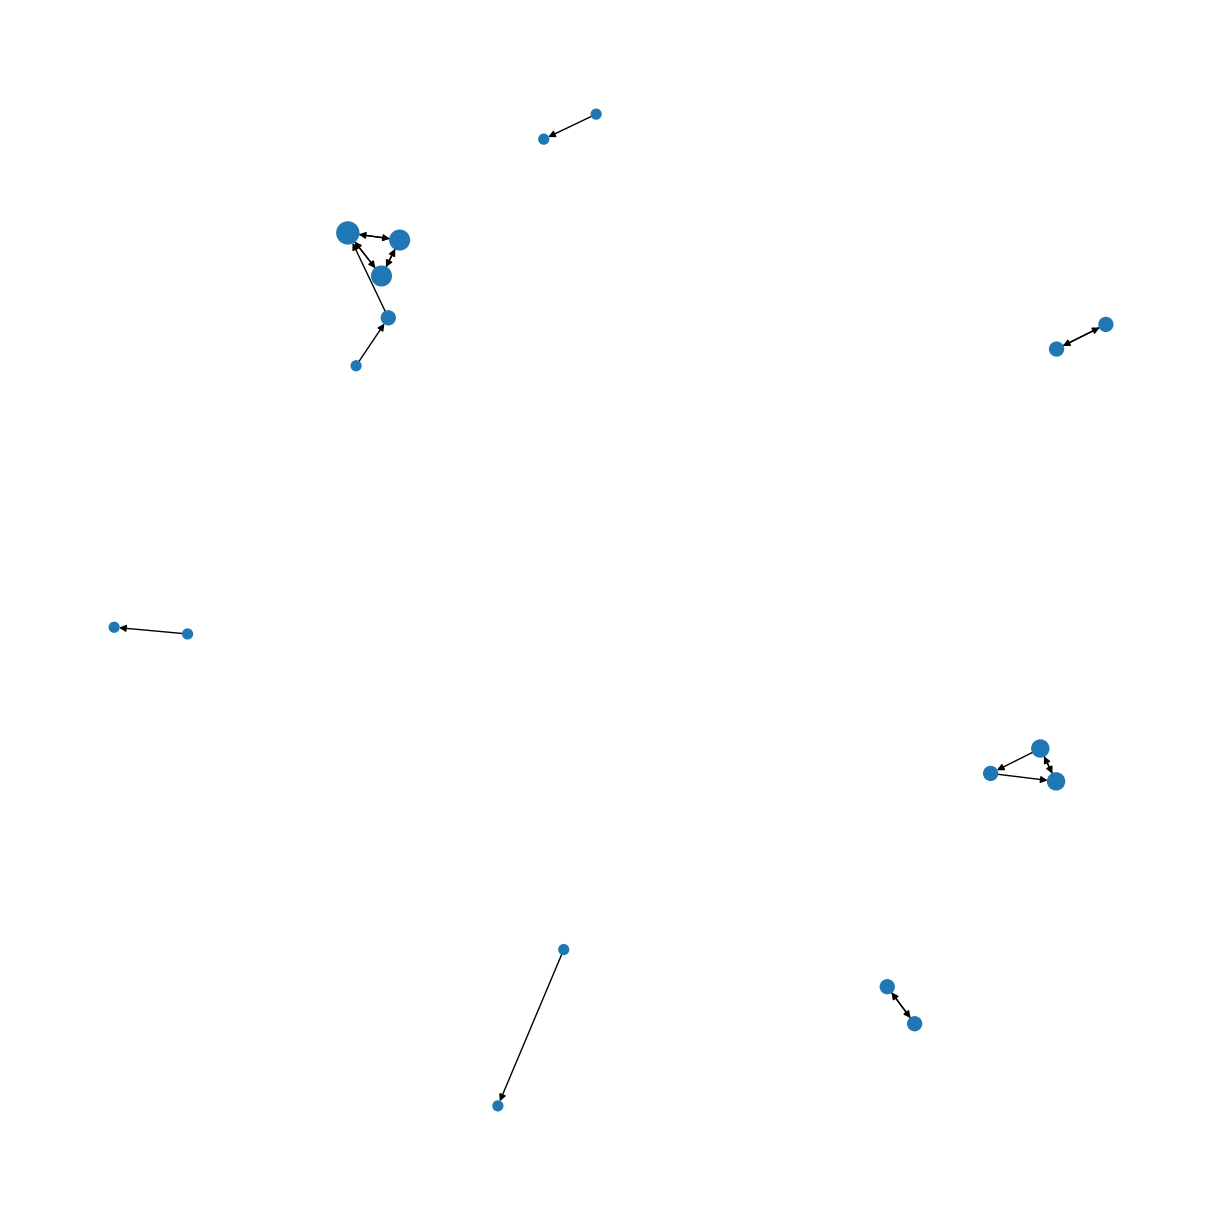

In [32]:
# networkx 画图
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
nodes = graph.get_nodes(1)
print(len(nodes))
edges = graph.get_edges(1)
# print(nodes)
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

d = dict(G.degree)
nx.draw(G, pos=nx.spring_layout(G), node_size=[v * 50 for v in d.values()])
plt.show()